In [1]:
from sklearn.datasets import fetch_mldata
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
%config IPCompleter.greedy=True

In [2]:
#fetch the data
mnist = fetch_mldata('MNIST original')

In [3]:
#get data and targets
target = mnist.target.reshape(mnist.target.shape[0], 1)
data = mnist.data

print ('shape of data and targets')
print ('\ndata shape: ', data.shape)
print ('target shape: ', target.shape)

shape of data and targets

data shape:  (70000, 784)
target shape:  (70000, 1)


In [4]:
#train/test split (MNIST data set is already ready for split)
print ('splitting data to train and test sets')
X_train, X_test, y_train, y_test = data[:60000], data[60000:], target[:60000], target[60000:]

#shuffle training set so that same numbers don't appear in a row
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

splitting data to train and test sets


In [5]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train.ravel())

#under the hood, scikit is training 10 binary classifiers (one for each class - OvA).
#when predicting, it will take the most confident classifier
print ('training SGD classifier...')

training SGD classifier...


In [6]:
some_digit = X_train[30000]
prediction = sgd_clf.predict(some_digit.reshape(1, -1))
actual = y_train[30000]
print ('prediction: {}, actual: {}'.format(prediction, actual))

prediction: [ 0.], actual: [ 0.]


results of the 10 classifiers: 
 [[  647039.25546086 -1161869.24473844  -646038.59716516  -492081.29397181
  -1207374.66983261  -898015.83082565 -1096562.94827807  -706286.17642321
   -657366.08425288 -1126127.79150765]]


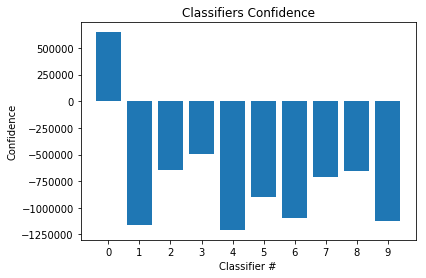

In [7]:
#see the results of the 10 classifiers
some_digit_scores = sgd_clf.decision_function([some_digit])
print ('results of the 10 classifiers: \n', some_digit_scores)

def plot_classifiers_confidence(scores):  
    plt.xlabel('Classifier #')
    plt.ylabel('Confidence')
    plt.title('Classifiers Confidence')
    x_axis = range(0, scores.shape[1])
    plt.xticks(x_axis)
    plt.bar(x_axis, scores.ravel())

plot_classifiers_confidence(some_digit_scores)

In [8]:
from sklearn.ensemble import RandomForestClassifier

#train a random forest classifier
print ('Training Random Forest classifier...')
random_forest_clf = RandomForestClassifier(random_state=42)
random_forest_clf.fit(X_train, y_train.ravel())

Training Random Forest classifier...


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

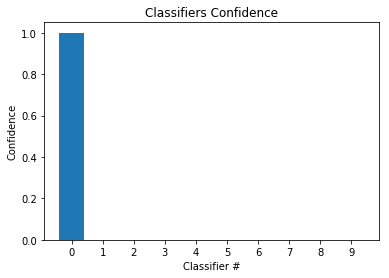

In [9]:
#see random forest classifiers confidence levels
clf_probs = random_forest_clf.predict_proba([some_digit])
plot_classifiers_confidence(clf_probs)

In [10]:
from sklearn.model_selection import cross_val_score

print('Computing accuracy for SGD classifier...')
cross_val_score(sgd_clf, X_train, y_train.ravel(), cv=3, scoring="accuracy")

Computing accuracy for SGD classifier...


array([ 0.8464807 ,  0.85289264,  0.83477522])

In [11]:
from sklearn.preprocessing import StandardScaler

print ('Adding a standard scaler and testing accuracy...')

#standard scarler will transform each value to a Z-score. Will help 
#the model to converge faster - better accuracy in same amount of time 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train.ravel(), cv=3, scoring="accuracy")

Adding a standard scaler and testing accuracy...


array([ 0.91011798,  0.90984549,  0.90873631])

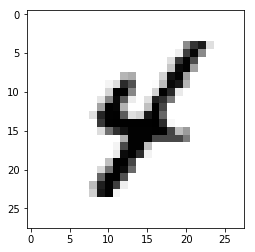

In [14]:
digit = data[30001].reshape(28, 28)
plt.imshow(digit, cmap = matplotlib.cm.binary, interpolation="nearest")

In [15]:
prediction = sgd_clf.predict(digit.reshape(1, -1))
print ('prediction: {}'.format(prediction))

prediction: [ 4.]


In [16]:
from sklearn.model_selection import cross_val_predict

#cross-validation
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train.ravel(), cv=3)

[[5733    4   30   10   12   39   41   11   38    5]
 [   2 6487   48   26    5   35    7   10  110   12]
 [  54   34 5361   96   82   21   79   51  166   14]
 [  45   39  133 5359    2  231   33   54  143   92]
 [  20   31   38   13 5342    7   54   32   81  224]
 [  70   43   32  189   67 4590  114   29  196   91]
 [  32   25   59    2   48   79 5618    8   47    0]
 [  19   22   72   31   47   12    6 5816   16  224]
 [  48  155   78  168   15  147   57   22 5029  132]
 [  47   32   25   89  171   38    2  225   81 5239]]


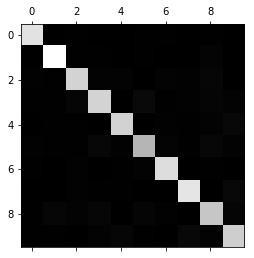

In [17]:
from sklearn.metrics import confusion_matrix

#confusion matrix - Mij: number of class i that was predicted as class j
#rows - actual, columns - predicted
conf_mx = confusion_matrix(y_train, y_train_pred)
print (conf_mx)
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

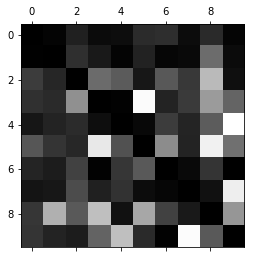

In [19]:
#error analysis

#normalizing conf matrix values
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

#fill diagonal with zeros to keep only the errors
#here, bright = error
#for example, notice columns 8,9 are bright. many digits are 
#missclassified as 8,9
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()


<h2>Exercise Questions</h2>
1. Reach 97% accuracy on the test set

In [20]:
print ('SGD Accuracy on test set: ', sgd_clf.score(X_test, y_test))
print ('Random Forest Accuracy on test set: ',random_forest_clf.score(X_test, y_test))

SGD Accuracy on test set:  0.8837
Random Forest Accuracy on test set:  0.9481


In [ ]:
from sklearn.model_selection import GridSearchCV

#using grid search on the random forest classifier
param_grid = [
        {'n_estimators': [10, 30], 'max_features': [500, 600, 700]},
        {'bootstrap': [False], 'n_estimators': [8, 10], 'max_features': [400, 600]},
]

#train model with grid search and cv. good for small set of hyper parameters
print ('\nGrid search fitting for random forest regressor. May take some time...')
forest_clf = RandomForestClassifier()
grid_search = GridSearchCV(forest_clf, param_grid, cv=3, verbose=10)
grid_search.fit(X_train, y_train.ravel())

print ('\nRandom forest regressor grid search best params: ')
print (grid_search.best_params_)


Grid search fitting for random forest regressor. May take some time...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] max_features=500, n_estimators=10 ...............................
[CV]  max_features=500, n_estimators=10, score=0.943761, total=  45.1s
[CV] max_features=500, n_estimators=10 ...............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   45.3s remaining:    0.0s


[CV]  max_features=500, n_estimators=10, score=0.942747, total=  46.4s
[CV] max_features=500, n_estimators=10 ...............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.5min remaining:    0.0s


[CV]  max_features=500, n_estimators=10, score=0.943642, total=  43.6s
[CV] max_features=500, n_estimators=30 ...............................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.3min remaining:    0.0s


[CV]  max_features=500, n_estimators=30, score=0.956809, total= 2.2min
[CV] max_features=500, n_estimators=30 ...............................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  4.5min remaining:    0.0s


[CV]  max_features=500, n_estimators=30, score=0.954298, total= 2.2min
[CV] max_features=500, n_estimators=30 ...............................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.7min remaining:    0.0s


[CV]  max_features=500, n_estimators=30, score=0.954293, total= 2.2min
[CV] max_features=600, n_estimators=10 ...............................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  8.9min remaining:    0.0s
